In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
from math import log 

from prml.utils.datasets import load_iris

# Utils

In [3]:
# Gauss 
def gauss(x,mu,s):
    #:params x: 1-D array data 
    #:prams mu,s: \mu and \sigma 
    #:return: \phi(x) 
    d = x.shape[0]
    m = mu.shape[0]
    phi = np.exp(-(x.reshape(-1,1) - mu)/(2*s**2))
    phi = np.concatenate(([1],phi.ravel()))
    return phi
    

# make 2-class toy data 
def make_2class_data(outlier=False):
    X1 = np.random.rand(30).reshape(-1,1)*5 
    X2 = np.random.rand(30).reshape(-1,1)*5 
    if outlier:
        X3 = np.random.rand(10).reshape(-1,1)*2 + 6
    
    Y1 = X1 + 2 + np.random.randn(30).reshape(-1,1)*0.6  
    Y2 = X2 + np.random.randn(30).reshape(-1,1)*0.6
    if outlier:
        Y3 = X3 - 10 + np.random.randn(10).reshape(-1,1)*0.6 
    
    if outlier:
        X = np.block([
            [X1,Y1],
            [X2,Y2],
            [X3,Y3]
        ])
    else:
        X = np.block([
            [X1,Y1],
            [X2,Y2]
        ])
    
    y = np.zeros_like(X)
    y[:,0] = np.where(X[:,1] > X[:,0] + 1,1,0)
    y[:,1] = np.where(X[:,1] < X[:,0] + 1,1,0)
    return X,y

# make 3-class toy data
def make_3class_data():
    X1 = np.random.rand(30).reshape(-1,1)*3 
    X2 = np.random.rand(30).reshape(-1,1)*3 + 1
    X3 = np.random.rand(30).reshape(-1,1)*3 + 2 
    Y1 = X1 + 8 + np.random.randn(30).reshape(-1,1)*0.6
    Y2 = X2 + 4 + np.random.randn(30).reshape(-1,1)*0.6
    Y3 = X3 + np.random.randn(30).reshape(-1,1)*0.6
    X = np.block([
            [X1,Y1],
            [X2,Y2],
            [X3,Y3]
    ])
    y = np.zeros((X.shape[0],3))
    y[:,0] = np.where(X[:,1] > X[:,0] + 6,1,0)
    class1 = np.logical_and((X[:,1] < X[:,0] + 6),(X[:,1] > X[:,0] + 2))
    y[:,1] = np.where(class1,1,0)
    y[:,2] = np.where(X[:,1] < X[:,0] + 2,1,0)
    return X,y

# make non-linear data 
def make_non_linear_data(n=20):
    X = np.random.randn(n)*3
    Y = np.random.randn(n)*3 
    data = np.concatenate((X.reshape(-1,1),Y.reshape(-1,1)),axis = 1)
    label = np.zeros((n,2))
    label[Y > X**3 - 3*X,0] = 1.0 
    label[Y < X**3 - 3*X,1] = 1.0
    return data,label

# transform one-hot-encoded target to label-encoded target
class OnehotToLabel():
    def __init__(self):
        self.K = None 
    def fit(self,X):
        #:params X: 2-D array 
        self.K = X.shape[1] 
        
    def transform(self,X):
        y = np.zeros(X.shape[0])
        for k in range(self.K):
            y[X[:,k] == 1] = k 
        return y
    
    def fit_transform(self,X):
        self.fit(X)
        return self.transform(X)
    

# plot decision region 
color = ["red","blue","lightgreen","yellow","orange","purple","pink"] 
def plot_classifier(X_tr,y_tr,classifier,title=""):
    if y_tr.ndim == 2:
        to = OnehotToLabel() 
        y_tr = to.fit_transform(y_tr) 
    cmap = ListedColormap(color[:len(np.unique(y_tr))])
    x_min,y_min = X_tr.min(axis = 0)
    x_max,y_max = X_tr.max(axis = 0) 
    x_min,y_min = x_min-0.1,y_min-0.1
    x_max,y_max = x_max+0.1,y_max+0.1
    x = np.linspace(x_min,x_max,100)
    y = np.linspace(y_min,y_max,100) 
    xs,ys = np.meshgrid(x,y)
    labels = classifier.predict(np.array([xs.ravel(),ys.ravel()]).T)
    if labels.ndim == 2:
        labels = to.transform(labels)
    labels = labels.reshape(xs.shape)
    
    figure,axes = plt.subplots(1,1,figsize=(10,7))
    axes.contourf(xs,ys,labels,alpha=0.3,cmap=cmap)
    axes.set_xlim(x_min,x_max)
    axes.set_ylim(y_min,y_max)
    for idx,label in enumerate(np.unique(y_tr)):
        axes.scatter(x=X_tr[y_tr == label,0],
                    y=X_tr[y_tr == label,1],
                    alpha=0.8,
                    c=color[idx],
                    label=label)
    axes.set_title(title)
    plt.legend()
    plt.show()

# Least squares for classification 

In [4]:
class LinearClassifier():
    # loss : mean_squared_error 
    def __init__(self):
        self.weight = None
        self.K = None 
    
    def fit(self,X,y):
        #:params X: 2-D array (N_samples,N_dims)
        #:params y: 2-D array (N_samples,N_classes) one-hot-encode
        self.K = y.shape[1]
        one = np.ones((X.shape[0],1))
        X = np.hstack((one,X))
        self.weight = np.linalg.inv(X.T@X)@X.T@y 
    
    def predict(self,X):
        #:params X: 2-D array (N_samples,N_dims)
        #:return: 2-D array (N_samples,N_classes) one-hot-encode
        one = np.ones((X.shape[0],1))
        X = np.hstack((one,X))
        y = X@self.weight
        label = y.argmax(axis = 1)
        onehot = np.zeros_like(y)
        for k in range(self.K):
            onehot[label == k,k] = 1 
        return onehot 

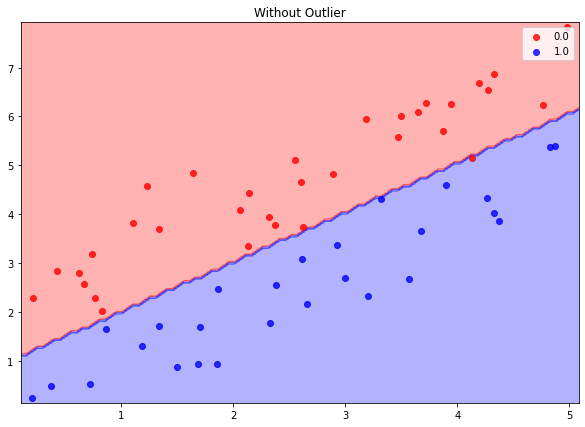

In [5]:
X,y = make_2class_data(outlier=False)
lc = LinearClassifier()
lc.fit(X,y)
plot_classifier(X,y,lc,title="Without Outlier")

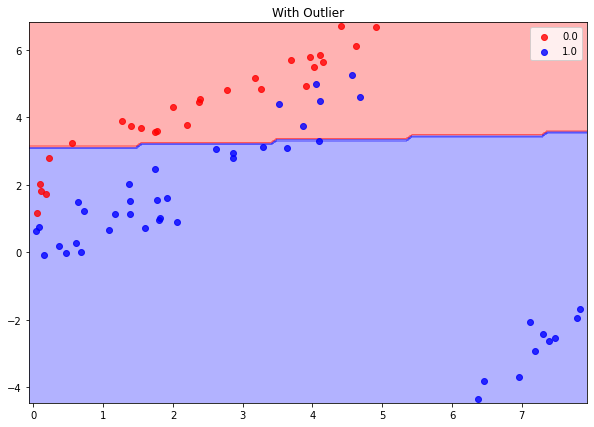

In [6]:
X,y = make_2class_data(outlier=True)
lc = LinearClassifier()
lc.fit(X,y)
plot_classifier(X,y,lc,title="With Outlier")

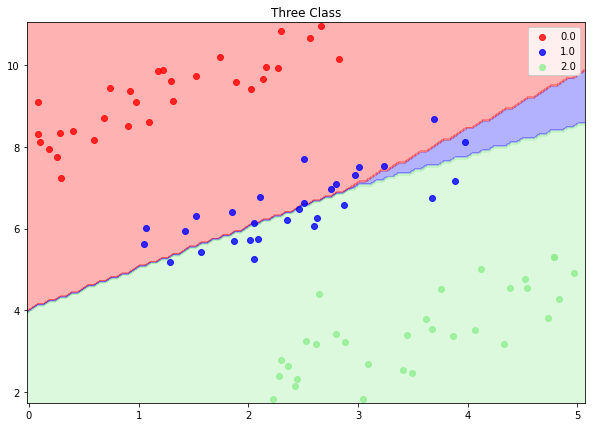

In [7]:
X,y = make_3class_data()
lc = LinearClassifier()
lc.fit(X,y)
y_pred = lc.predict(X)
plot_classifier(X,y,lc,title="Three Class")

# Fisher's linear discriminant

<h3>
    $$S_W = \sum_{n \in C_1}(x_n - m_1)(x_n - m_1)^\top + \sum_{n \in C_2}(x_n - m_2)(x_n - m_2)^\top$$
</h3>

In [8]:
class Fisher1D():
    def __init__(self):
        self.weight = None 
        
    def fit(self,X,y):
        #:params X: 2-D array (N_samples,N_dim)
        #:params y: 2-D array (N_samples,2) one-hot-encode
        class0 = X[y[:,0] == 1]
        class1 = X[y[:,1] == 1]
        m1 = class0.mean(axis = 0)
        m2 = class1.mean(axis = 0)
        S_w = (class0 - m1).T@(class0 - m1) + (class1 - m2).T@(class1 - m2)
        self.weight = np.linalg.inv(S_w)@(m2 - m1).reshape(-1,1) 
        
    def transform(self,X):
        return (X@self.weight).ravel()
    
    def fit_transform(self,X,y):
        self.fit(X,y)
        return self.transform(X)

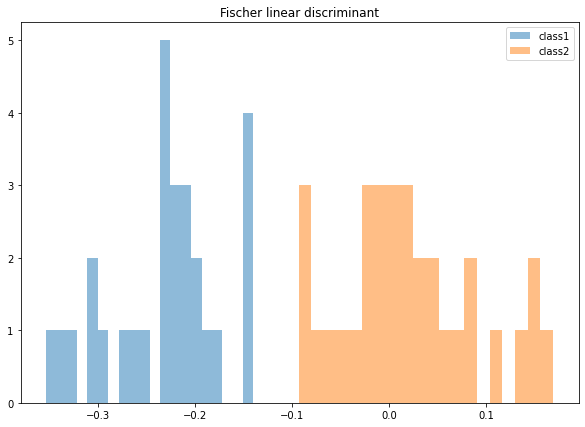

In [9]:
X,y = make_2class_data(outlier=False)
fisher1d = Fisher1D()
X_1d = fisher1d.fit_transform(X,y)

X_1d_class1 = X_1d[y[:,0] == 1]
X_1d_class2 = X_1d[y[:,1] == 1]

fig = plt.figure(figsize=(10,7)) 
ax = fig.add_subplot(1,1,1)
ax.hist(X_1d_class1,bins=20,alpha=0.5,label="class1")
ax.hist(X_1d_class2,bins=20,alpha=0.5,label="class2") 
ax.set_title("Fischer linear discriminant")
plt.legend()
plt.show()

In [10]:
class Fisher():
    def __init__(self,n_components=None):
        self.weight = None
        self.n_components = n_components 
        
    def fit(self,X,y):
        #:params X: 2-D array (N_samples,N_dim)
        #:params y: 2-D array (N_samples,N_classes) one-hot-encode
        K = y.shape[1]
        D = X.shape[1]
        m = X.mean(axis = 0) 
        S_W = np.zeros((D,D))
        S_B = np.zeros((D,D))
        for k in range(K):
            X_k = X[y[:,k] == 1]
            m_k = X_k.mean(axis = 0) 
            S_W += (X_k - m_k).T@(X_k - m_k)
            S_B += X_k.shape[0]*(m_k - m)@(m_k - m).T
        _,eigen_vec = np.linalg.eig(np.linalg.inv(S_W)@S_B)
        if self.n_components is not None:
            self.weight = eigen_vec[:,:self.n_components]
        else:
            self.weight = eigen_vec[:,:K]  
        
    def transform(self,X):
        return X@self.weight
    
    def fit_transform(self,X,y):
        self.fit(X,y)
        return self.transform(X)

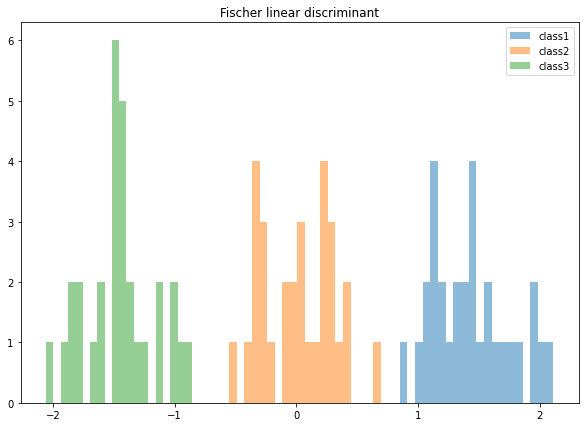

In [11]:
fisher = Fisher(n_components=1) 
X,y = make_3class_data()
m = X.mean(axis = 0)
s = X.std(axis = 0)
X = (X - m)/s
X_1d = fisher.fit_transform(X,y)

X_1d_class1 = X_1d[y[:,0] == 1]
X_1d_class2 = X_1d[y[:,1] == 1]
X_1d_class3 = X_1d[y[:,2] == 1] 

fig = plt.figure(figsize=(10,7)) 
ax = fig.add_subplot(1,1,1)
ax.hist(X_1d_class1,bins=20,alpha=0.5,label="class1")
ax.hist(X_1d_class2,bins=20,alpha=0.5,label="class2") 
ax.hist(X_1d_class3,bins=20,alpha=0.5,label="class3") 
ax.set_title("Fischer linear discriminant")
plt.legend()
plt.show()

# Perceptron Algorithum

In [12]:
class Perceptron():
    def __init__(self,learning_rate=1e-3,n_iter=100):
        self.learning_rate = learning_rate 
        self.n_iter = n_iter
        self.weight = None 
        self.phi = lambda x: np.concatenate(([1],x))
        
    def fit(self,X,y):
        #:params X: 2-D array (N_samples,N_dims)
        #:params y: 2-D array (N_samples,2) onehotencoding
        
        # make y to 1-D array and value is 1 or -1 
        new_y = np.zeros(X.shape[0])
        new_y[y[:,0] == 1] = -1
        new_y[y[:,1] == 1] = 1
        y = new_y
        
        M = X.shape[1] + 1
        self.weight = np.random.randn(M,1) 
        for _ in range(self.n_iter):
            y_pred = self._predict(X)
            incorrect = X[y_pred*y < 0]
            slope = np.vstack([self.phi(x)*y[i] for i,x in enumerate(incorrect)]).sum(axis = 0) 
            self.weight += self.learning_rate*slope.reshape(-1,1)
    
    def _predict(self,X):
        #:params X: 2-D array (N_samples,N_dims)
        #:return y_pred: 1-D array (N_samples,) value is -1 or 1 
        # for training
        
        design_mat = np.vstack([self.phi(x) for x in X])
        return np.where(design_mat@self.weight > 0,1,-1).ravel()
        
    def predict(self,X):
        #:params X: 2-D array (N_samples,N_dims)
        #:return y_pred: 2-D array (N_samples,2) onehotencoding
        
        design_mat = np.vstack([self.phi(x) for x in X])
        pred = (design_mat@self.weight).ravel()
        y = np.zeros((X.shape[0],2))
        y[pred < 0,0] = 1
        y[pred > 0,1] = 1
        return y

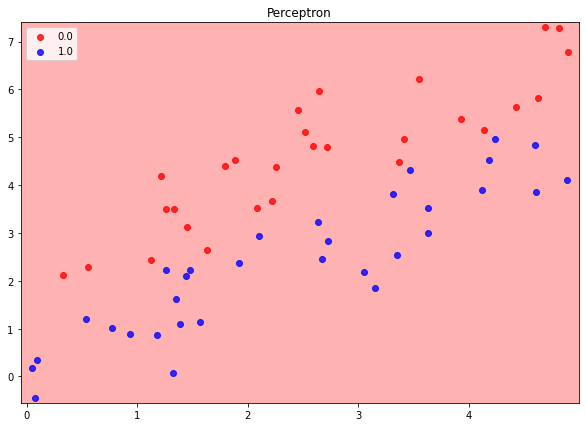

In [13]:
X,y = make_2class_data()
pn = Perceptron(learning_rate=1e-6,n_iter=30)
pn.fit(X,y)
plot_classifier(X,y,pn,title="Perceptron") # very unstable?

# Probabilistic Generative Model

In [14]:
class GenerativeClassifier():
    # only 2class 
    # Maximum Likelihood solution
    def __init__(self):
        self.pi = 0
        self.mu1 = None 
        self.mu2 = None 
        self.sigma = None 
        
        self.weight = None 
        self.b = 0 
    
    def fit(self,X,y):
        #:params X: 2-D array (N_samples,N_dims)
        #:params y: 2-D array (N_samples,2) onehotencoding 
        
        # make y to 1-D array and value is 1 or 0 
        new_y = np.zeros(X.shape[0])
        new_y[y[:,0] == 1] = 0 
        new_y[y[:,1] == 1] = 1
        y = new_y
        
        N1 = y.sum() 
        N2 = y.shape[0] - N1
        N = N1 + N2
        pi = N1/(N1 + N2) 
        
        X1 = X[y == 1]
        X2 = X[y == 0]
        mu1 = X1.sum(axis = 0)/N1 
        mu2 = X2.sum(axis = 0)/N2 
        
        S1 = (X1 - mu1).T@(X1 - mu1)/N1 
        S2 = (X2 - mu2).T@(X2 - mu2)/N2 
        sigma = N1/N*S1 + N2/N*S2    
        
        Sinv = np.linalg.inv(sigma)
        self.weight = np.dot(Sinv,mu1 - mu2) 
        self.b = -mu1.T@np.dot(Sinv,mu1)/2 + mu2.T@np.dot(Sinv,mu2)/2 + log(pi/(1.0 - pi))
        
        self.pi = pi 
        self.mu1 = mu1 
        self.mu2 = mu2 
        self.sigma = sigma 
        
    def predict(self,X):
        #:params X: 2-D array (N_samples,N_dims)
        #:params y: 2-D array (N_samples,2) onehotencoding 
        
        logit = X@self.weight + self.b 
        prob = 1/(1 + np.exp(-logit))
        y = np.zeros((X.shape[0],2))
        y[prob <= 0.5,0] = 1 
        y[prob > 0.5,1] = 1
        return y
    
    def generate(self,size = 20):
        x = np.random.rand(size) 
        
        X = np.zeros((size,len(self.weight)))
        y = np.zeros((size,2)) 
        y[x >= self.pi,0] = 1 
        y[x < self.pi,1] = 1
        
        class1 = (x < self.pi).astype("int").sum()
        X[x >= self.pi,:] = np.random.multivariate_normal(self.mu2,self.sigma,size - class1) 
        X[x < self.pi,:] = np.random.multivariate_normal(self.mu1,self.sigma,class1)
        
        return X,y

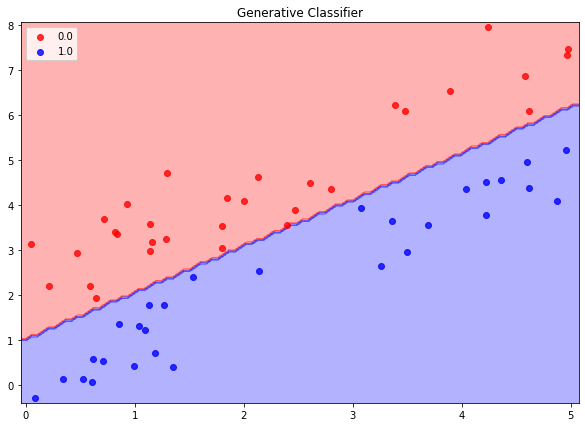

In [15]:
X,y = make_2class_data()
generater = GenerativeClassifier()
generater.fit(X,y)
plot_classifier(X,y,generater,title="Generative Classifier")

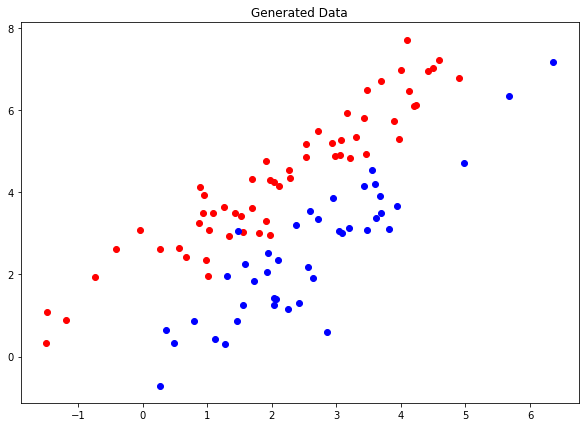

In [16]:
X_gen,y_gen = generater.generate(size = 100)
X_gen1 = X_gen[y_gen[:,0] == 1] 
X_gen2 = X_gen[y_gen[:,1] == 1]

fig,ax = plt.subplots(figsize=(10,7))
ax.scatter(X_gen1[:,0],X_gen1[:,1],color = "red")
ax.scatter(X_gen2[:,0],X_gen2[:,1],color = "blue")
ax.set_title("Generated Data")
plt.show()

# Probabilistic Discriminative Models

In [17]:
# sigmoid
def sigmoid(x):
    # :params x: array 
    # :return sig: array 1/(1 + exp(-x))
    
    sig = np.zeros_like(x)
    plus = x[x >= 0]
    minus = x[x < 0] 
    sig[x >= 0] = 1/(1 + np.exp(-plus))
    sig[x < 0] = np.exp(minus)/(np.exp(minus) + 1)
    return sig 

# binary cross entropy
def binary_cross_entropy(target,pred):
    # :params target: 2-D array (N_samples,1) value should be 0 or 1 
    # :params pred: 2-D array (N_samples,1)  value should be in (0,1)
    
    # or 
    
    # :params target: 2-D array (N_samples,2) onehotencoding 
    # :params pred: 2-D array (N_samples,2)  value should be in (0,1)
    
    if target.shape[1] == 1:
        loss = -target*np.log(pred) - (1.0 - target)*np.log(1.0 - pred) 
    else:
        loss = target*np.log(pred) 
        loss = -loss.sum(axis = 0)
    return loss.mean()  

In [18]:
class LogisticRegression():
    def __init__(self,max_iter = 30,threshold = 1e-2,mu = np.random.randn(5),s = np.random.randn(5)):
        self.max_iter = max_iter 
        self.threshold = threshold
        self.mu = mu
        self.s = s
        self.phi = lambda x:gauss(x,self.mu,self.s)
        self.weight = None 
        
    def fit(self,X,y):
        target = np.zeros(y.shape[0]).reshape(-1,1)
        target[y[:,1] == 1] = 1
        #:params X: 2-D array (N_samples,N_dims)
        #:params y: 2-D array (N_samples,2) onehotencoding 
        # for 2-class classification
        
        design_mat = np.vstack([self.phi(x) for x in X])
        self.weight = np.random.randn(design_mat.shape[1]).reshape(-1,1)
        for _ in range(self.max_iter):
            # IRLS
            y = sigmoid(design_mat@self.weight)
            if binary_cross_entropy(target,y) < self.threshold:
                break 
            R = y*(1.0 - y)
            z = design_mat@self.weight - (y - target)/R 
            self.weight = np.linalg.pinv(design_mat.T@(R*design_mat))@design_mat.T@(R*z)
        
    def predict(self,X,return_prob=False):
        #:params X: 2-D array (N_samples,N_dims)
        #:params return_prob: if True return probability 
        #:return y: 2-D array (N_samples,2) 
        
        design_mat = np.vstack([self.phi(x) for x in X])
        logit = (design_mat@self.weight).ravel() 
        if return_prob:
            prob1 = sigmoid(logit) 
            y = np.zeros((X.shape[0],2))
            y[:,1] = prob1 
            y[:,0] = 1.0 - prob1 
        else:
            y = np.zeros((X.shape[0],2))
            y[logit < 0,0] = 1
            y[logit >= 0,1] = 1 
        return y

In [19]:
X, y = load_iris()
X = X[y != 2,:2]
y = y[y != 2]
t = np.zeros((y.shape[0],2))
t[y == 0,0] = 1
t[y == 1,1] = 1

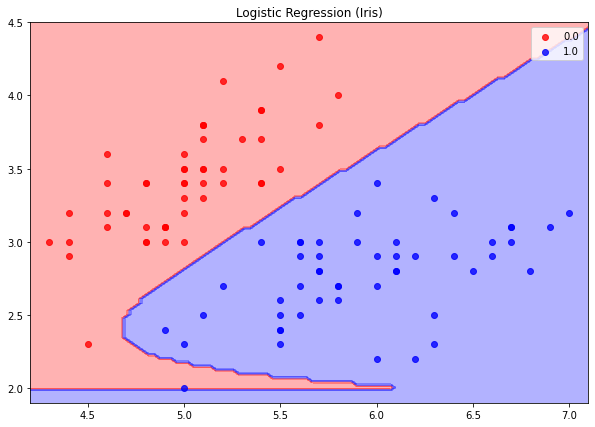

In [20]:
mu = np.array([-1,2,-0.2,4,1,0.2])
s = np.array([0.1,0.03,0.03,2,0.3,0.01])

lr = LogisticRegression(max_iter=30,threshold=1e-3,mu = mu,s = s)
lr.fit(X,t)
plot_classifier(X,t,lr,title="Logistic Regression (Iris)")

In [21]:
prob = lr.predict(X,return_prob=True)
print("Probability ")
print(prob[:5,:])

Probability 
[[9.99999450e-01 5.50066687e-07]
 [9.98258391e-01 1.74160927e-03]
 [9.99999814e-01 1.85526041e-07]
 [9.99999749e-01 2.50872960e-07]
 [9.99999993e-01 6.56844334e-09]]


In [22]:
# softmax 
def softmax(x):
    # :params x: 2-D array (N_samples,N_class) 
    # :return prob: 2-D array (N_samples,N_class) 
    
    row_max = x.max(axis = 1).reshape(-1,1)
    x -= row_max 
    ratio = np.exp(x) 
    total = ratio.sum(axis = 1).reshape(-1,1)
    return ratio/total 

# cross entropy 
def cross_entropy(target,pred):
    # :params target: 2-D array (N_samples,N_class) onehotencoding 
    # :params pred: 2-D array (N_samples,N_class)  value should be in (0,1)
    
    loss = target*np.log(pred) 
    return -loss.mean()

In [23]:
class MultiClassLogisticRegression():
    def __init__(self,max_iter = 30,threshold = 1e-2,learning_rate=1e-2,mu = np.random.randn(5),s = np.random.randn(5)):
        self.max_iter = max_iter
        self.threshold = threshold
        self.learning_rate = learning_rate
        self.mu = mu 
        self.s = s
        self.phi = lambda x:gauss(x,mu,s)
        self.weight = None 
        self.losses = [] 
        
    def fit(self,X,y): 
        # :params X: 2-D array (N_samples,N_dims)
        # :params y: 2-D array (N_samples,N_class) onehotencoding 
        
        design_mat = np.vstack([self.phi(x) for x in X])
        self.weight = np.random.randn(design_mat.shape[1],y.shape[1]) # (dims in feature space,class) 
        
        # Gradient Descent Method 
        for _ in range(self.max_iter):
            probability = softmax(design_mat@self.weight)
            loss = cross_entropy(y,probability)
            self.losses.append(loss)
            if loss < self.threshold:
                break 
            self.weight -= self.learning_rate*design_mat.T@(probability - y)   
        
    def predict(self,X,return_prob=False):
        # :params X: 2-D array (N_samples,N_dims) 
        # :params return_prob: if True, return probabilities 
        
        # :return probability: 2-D array (N_samples,N_classes) 
        
        design_mat = np.vstack([self.phi(x) for x in X])
        logit = design_mat@self.weight 
        if return_prob:
            return softmax(logit)
        else:
            x = softmax(logit)
            idx = np.argmax(x,axis = 1)  
            y = np.zeros_like(x) 
            for k in range(x.shape[1]):
                y[idx == k,k] = 1
            return y

In [25]:
X, y = load_iris()
X = X[:,:2]
t = np.zeros((y.shape[0],3))
t[y == 0,0] = 1 
t[y == 1,1] = 1
t[y == 2,2] = 1

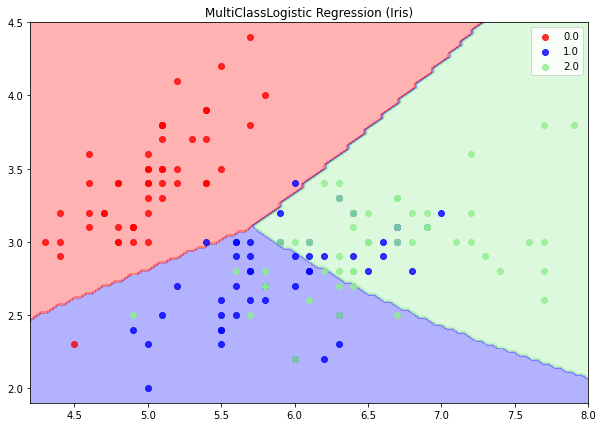

In [26]:
mclr = MultiClassLogisticRegression(max_iter=1000,mu = np.array([0.1,-0.4,0,-0.5,0.5,-1,0.4]),s = np.array([1,0.3,0.03,5,0.3,2.4,0.3]))
mclr.fit(X,t)  
plot_classifier(X,t,mclr,title="MultiClassLogistic Regression (Iris)")

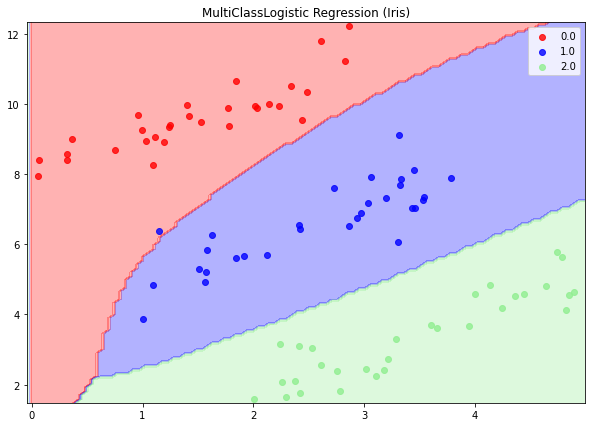

In [27]:
X,y = make_3class_data()
mclr = MultiClassLogisticRegression(max_iter=1000,mu = np.array([0.1,-0.4,0,-0.5,0.5,-1,0.4]),s = np.array([1,0.3,0.03,5,0.3,2.4,0.3]))
mclr.fit(X,y)  
plot_classifier(X,y,mclr,title="MultiClassLogistic Regression (Iris)")

# Bayesian Logistic Regression

In [28]:
def kappa(sigma):
    return (1 + np.pi*sigma/8)**(-0.5)

In [29]:
class BayesianLogisticRegression():
    def __init__(self,alpha=1e-2,max_iter=30,threshold=1e-2,learning_rate=1e-2,mu = np.random.randn(5),s = np.random.randn(5)):
        self.alpha = alpha 
        self.max_iter = max_iter
        self.threshold = threshold 
        self.learning_rate = learning_rate
        self.mu = mu 
        self.s = s 
        self.phi = lambda x:gauss(x,self.mu,self.s)
        self.weight = None 
        self.S = None 
        self.losses = []
    
    def fit(self,X,y):
        # :params X: 2-D array (N_samples,N_dims)
        # :params y: 2-D array (N_samples,2) ohehotencoding or 1-D array (N_samples)
        
        if y.ndim == 2:
            y_ = np.zeros(X.shape[0]).reshape(-1,1)
            y_[y[:,1] == 1] = 1
            y = y_ 
        else:
            y = y.reshape(-1,1)
            
        design_mat = np.vstack([self.phi(x) for x in X])
        self.weight = np.random.randn(design_mat.shape[1]).reshape(-1,1) 
        
        for _ in range(self.max_iter):
            probability = sigmoid(design_mat@self.weight)
            loss = binary_cross_entropy(y,probability)
            self.losses.append(loss)
            if loss < self.threshold:
                break
            self.weight -= self.learning_rate*(self.alpha*self.weight + design_mat.T@(probability - y))
        
        R = (probability*(1.0 - probability)).ravel()  
        self.S = 1/self.alpha*np.eye(self.weight.shape[1]) + (R*design_mat.T)@design_mat             
    
    def predict(self,X,return_prob=False):
        # :params X: 2-D array (N_samples,N_dims)
        # :params return_prob: if True, return probability
        # :return y: 2-D array (N_samples,2) 
        
        design_mat = np.vstack([self.phi(x) for x in X])
        logit = (design_mat@self.weight).ravel()
        if return_prob:
            sigma = np.diag(design_mat@self.S@design_mat.T) 
            prob1 = sigmoid(kappa(sigma)*logit)
            y = np.zeros((X.shape[0],2))
            y[:,1] = prob1 
            y[:,0] = 1.0 - prob1 
        else:
            y = np.zeros((X.shape[0],2))
            y[logit < 0,0] = 1
            y[logit >= 0,1] = 1 
        return y

In [30]:
X, y = load_iris()
X = X[y != 2,:2]
y = y[y != 2]
t = np.zeros((y.shape[0],2))
t[y == 0,0] = 1
t[y == 1,1] = 1

In [31]:
blr = BayesianLogisticRegression(max_iter=100,alpha=1e-10,mu = mu,s = s)
blr.fit(X,t) 

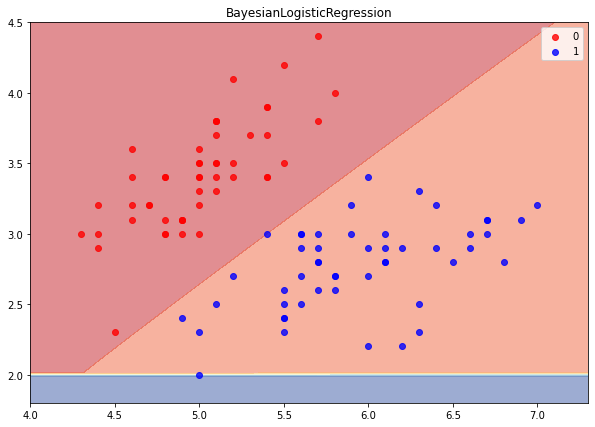

In [33]:
# plot probability 

x = np.linspace(4,7.5,100)
y = np.linspace(1.5,4.5,100)
xs,ys = np.meshgrid(x,y)
probs = blr.predict(np.array([xs.ravel(),ys.ravel()]).T,return_prob=True)[:,1].ravel() 
probs = probs.reshape(xs.shape)

cmap = plt.get_cmap("RdYlBu")
figure,axes = plt.subplots(1,1,figsize=(10,7))
axes.contourf(xs,ys,probs,alpha=0.5,cmap = cmap)
axes.set_xlim(4,7.3)
axes.set_ylim(1.8,4.5)

axes.scatter(x = X[t[:,0] == 1,0],
             y = X[t[:,0] == 1,1],
             alpha = 0.8,
             c = "red",
             label = "0")
axes.scatter(x = X[t[:,1] == 1,0],
             y = X[t[:,1] == 1,1],
             alpha = 0.8,
             c = "blue",
             label = "1")

axes.set_title("BayesianLogisticRegression")
plt.legend()
plt.show()
